# Pre processing

In [4]:
import keras.utils.metrics_utils
import numpy as np
import librosa
import pandas as pd
import os
from tqdm import tqdm

In [5]:
max_pad_len = 174

def extract_features(file_name):

    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')

    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None

    return mfccs

In [6]:
# Set the path to the full UrbanSound dataset
full_dataset_path = 'Data/UrbanSound8K/audio'
metadata = pd.read_csv('Data/UrbanSound8K/metadata/UrbanSound8K.csv')
features = []

# Iterate through each sound file and extract the features
for index, row in tqdm(metadata.iterrows()):

    file_name = os.path.join(os.path.abspath(full_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))

    class_label = row["class"]
    data = extract_features(file_name)

    features.append([data, class_label])

# Convert into a Panda dataframe
features_df = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(features_df), ' files')

3554it [02:16, 26.19it/s]C:\Users\masterdoc\anaconda3\envs\DeepLearning\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
8323it [05:12, 34.51it/s]C:\Users\masterdoc\anaconda3\envs\DeepLearning\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
C:\Users\masterdoc\anaconda3\envs\DeepLearning\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(
8732it [05:27, 26.64it/s]

Finished feature extraction from  8732  files


In [7]:
features_df

,feature,class_label
0,"[[-306.77255, -177.59209, -99.13616, -65.97198...",dog_bark
1,"[[-457.6953, -451.0248, -450.68613, -444.99997...",children_playing
2,"[[-468.0367, -467.42264, -481.04654, -486.5948...",children_playing
3,"[[-422.42215, -411.9085, -409.46243, -409.0892...",children_playing
4,"[[-438.10162, -434.47787, -443.3284, -442.6644...",children_playing
...,...,...
8727,"[[-397.82446, -400.45578, -407.5035, -408.9529...",car_horn
8728,"[[-451.81265, -451.41983, -450.67892, -445.635...",car_horn
8729,"[[-301.06348, -298.25397, -305.0326, -303.8614...",car_horn
8730,"[[-373.6307, -369.44986, -366.48, -364.9094, -...",car_horn


In [8]:
features_df.to_csv('features_df_index.csv', index=True)

In [9]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [10]:
# Convert features and corresponding classification labels into numpy arrays
X = np.array(features_df.feature.tolist())
y = np.array(features_df.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

# split the dataset

x_train_full, x_test, y_train_full, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.2, random_state = 42)

# CNN

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [12]:
num_rows = 40
num_columns = 174
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_val = x_val.reshape(x_val.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = yy.shape[1]
filter_size = 2

# Construct model
model_basic = Sequential()
model_basic.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model_basic.add(MaxPooling2D(pool_size=2))
model_basic.add(Dropout(0.2))

model_basic.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model_basic.add(MaxPooling2D(pool_size=2))
model_basic.add(Dropout(0.2))

model_basic.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model_basic.add(MaxPooling2D(pool_size=2))
model_basic.add(Dropout(0.2))

model_basic.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model_basic.add(MaxPooling2D(pool_size=2))
model_basic.add(Dropout(0.2))
model_basic.add(GlobalAveragePooling2D())

model_basic.add(Dense(num_labels, activation='softmax'))

# Compile the model

In [13]:
# Compile the model
model_basic.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [14]:
# Display model architecture summary
model_basic.summary()

# Calculate pre-training accuracy
score = model_basic.evaluate(x_val, y_val, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 39, 173, 16)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 86, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 19, 86, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 85, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 42, 32)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 9, 42, 32)         0

# Training

In [15]:
from keras.callbacks import ModelCheckpoint
from datetime import datetime

In [16]:
num_epochs = 72
num_batch_size = 256

checkpointer = ModelCheckpoint(
    filepath='saved_models_CNN/weights.best.basic_cnn.hdf5',
    verbose=1,
    save_best_only=True
)
start = datetime.now()
model_basic.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_val, y_val), callbacks=[checkpointer], verbose=1)

duration = datetime.now() - start
print(f'Trained the model in: {duration}')

Epoch 1/72
22/22 [==============================] - ETA: 0s - loss: 5.6332 - accuracy: 0.1705
Epoch 00001: val_loss improved from inf to 2.52932, saving model to saved_models_CNN\weights.best.basic_cnn.hdf5
22/22 [==============================] - 2s 48ms/step - loss: 5.6332 - accuracy: 0.1705 - val_loss: 2.5293 - val_accuracy: 0.1954
Epoch 2/72
22/22 [==============================] - ETA: 0s - loss: 2.2591 - accuracy: 0.2568
Epoch 00002: val_loss improved from 2.52932 to 1.95529, saving model to saved_models_CNN\weights.best.basic_cnn.hdf5
22/22 [==============================] - 1s 25ms/step - loss: 2.2591 - accuracy: 0.2568 - val_loss: 1.9553 - val_accuracy: 0.3164
Epoch 3/72
22/22 [==============================] - ETA: 0s - loss: 1.8939 - accuracy: 0.3312
Epoch 00003: val_loss improved from 1.95529 to 1.85334, saving model to saved_models_CNN\weights.best.basic_cnn.hdf5
22/22 [==============================] - 1s 25ms/step - loss: 1.8939 - accuracy: 0.3312 - val_loss: 1.8533 - va

# Metrics

In [17]:
score = model_basic.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model_basic.evaluate(x_val, y_val, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9005010724067688
Testing Accuracy:  0.8296349048614502


## Confusion matrix

In [18]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report

In [19]:
def confusion_matrix(x_test, y_test, target):
    predicted_vector = target.predict(x_test)
    classes_x = np.argmax(predicted_vector, axis=1)
    predicted_class = le.inverse_transform(classes_x)

    classes_y = np.argmax(y_test, axis=1)
    true_class = le.inverse_transform(classes_y)
    print(classification_report(true_class, predicted_class))

In [20]:
confusion_matrix(x_test, y_test, model_basic)

                  precision    recall  f1-score   support

 air_conditioner       0.84      0.96      0.90       203
        car_horn       0.74      0.98      0.84        86
children_playing       0.83      0.66      0.74       183
        dog_bark       0.99      0.63      0.77       201
        drilling       0.86      0.86      0.86       206
   engine_idling       0.84      0.93      0.88       193
        gun_shot       0.90      0.96      0.93        72
      jackhammer       0.92      0.95      0.94       208
           siren       0.80      0.94      0.86       165
    street_music       0.78      0.77      0.77       230

        accuracy                           0.85      1747
       macro avg       0.85      0.86      0.85      1747
    weighted avg       0.85      0.85      0.84      1747



# Heatmap

In [53]:
import seaborn as sns
from sklearn.metrics import confusion_matrix as cf
def heat_map(x_test, y_test, target):
    predicted_vector = target.predict(x_test)
    classes_x = np.argmax(predicted_vector, axis=1)
    predicted_class = le.inverse_transform(classes_x)

    classes_y = np.argmax(y_test, axis=1)
    true_class = le.inverse_transform(classes_y)
    ax = sns.heatmap(cf(true_class, predicted_class))

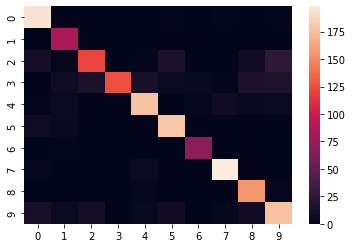

In [54]:
heat_map(x_test, y_test, model_basic)

# Predictions

In [24]:
def print_prediction(file_name, target):
    prediction_feature = extract_features(file_name)
    prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, num_channels)

    predicted_vector = target.predict(prediction_feature)
    classes_x = np.argmax(predicted_vector, axis=1)
    predicted_class = le.inverse_transform(classes_x)
    print("The predicted class is:", predicted_class[0], '\n')

    predicted_proba_vector = target.predict(prediction_feature)
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)):
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f'))

In [25]:
# Air conditioner
file_name = 'samples/100852-0-0-0.wav'
print_prediction(file_name, model_basic)

The predicted class is: air_conditioner 

air_conditioner 		 :  0.93232434988021850585937500000000
car_horn 		 :  0.00002944457264675293117761611938
children_playing 		 :  0.00198938813991844654083251953125
dog_bark 		 :  0.00001823407365009188652038574219
drilling 		 :  0.00667552230879664421081542968750
engine_idling 		 :  0.02055497467517852783203125000000
gun_shot 		 :  0.00015482208982575684785842895508
jackhammer 		 :  0.03789340332150459289550781250000
siren 		 :  0.00030287238769233226776123046875
street_music 		 :  0.00005689940735464915633201599121


In [27]:
# Drilling
file_name = 'samples/103199-4-0-0.wav'
print_prediction(file_name, model_basic)

The predicted class is: drilling 

air_conditioner 		 :  0.00000243364092966658063232898712
car_horn 		 :  0.00000258209252024244051426649094
children_playing 		 :  0.00001591095860931091010570526123
dog_bark 		 :  0.00001640665323066059499979019165
drilling 		 :  0.99586063623428344726562500000000
engine_idling 		 :  0.00007234972144942730665206909180
gun_shot 		 :  0.00000568887935514794662594795227
jackhammer 		 :  0.00052923709154129028320312500000
siren 		 :  0.00000022276857691849727416411042
street_music 		 :  0.00349460612051188945770263671875


In [28]:
# Street music
file_name = 'samples/101848-9-0-0.wav'
print_prediction(file_name, model_basic)

The predicted class is: street_music 

air_conditioner 		 :  0.00113205052912235260009765625000
car_horn 		 :  0.00691472319886088371276855468750
children_playing 		 :  0.02257700636982917785644531250000
dog_bark 		 :  0.00057672831462696194648742675781
drilling 		 :  0.00000466042138214106671512126923
engine_idling 		 :  0.00001532563692308031022548675537
gun_shot 		 :  0.00000000006087955833899982849289
jackhammer 		 :  0.00000135088612296385690569877625
siren 		 :  0.00485296547412872314453125000000
street_music 		 :  0.96392518281936645507812500000000


In [29]:
# Car horn
file_name = 'samples/100648-1-0-0.wav'
print_prediction(file_name, model_basic)

The predicted class is: drilling 

air_conditioner 		 :  0.00188682472798973321914672851562
car_horn 		 :  0.24110135436058044433593750000000
children_playing 		 :  0.00853456463664770126342773437500
dog_bark 		 :  0.14143005013465881347656250000000
drilling 		 :  0.24255423247814178466796875000000
engine_idling 		 :  0.00945129245519638061523437500000
gun_shot 		 :  0.11836099624633789062500000000000
jackhammer 		 :  0.21975129842758178710937500000000
siren 		 :  0.01350787747651338577270507812500
street_music 		 :  0.00342152873054146766662597656250


# Save model

In [30]:
from keras.models import model_from_json
# Serialize model to Json
model_json = model_basic.to_json()
with open('models/cnn.json', 'w') as json_file:
    json_file.write(model_json)

In [31]:
# Serialize weights to HDF5
model_basic.save_weights('models/cnn.h5')
print('Model saved')

Model saved


# Load the model and test it

In [32]:
json_file2 = open('models/cnn.json')
loaded_model_json = json_file2.read()
json_file2.close()

In [33]:
loaded_model = model_from_json(loaded_model_json)

# Load weights into new model
loaded_model.load_weights('models/cnn.h5')
print('Model loaded')

Model loaded


# Test the loaded model

In [34]:
file_name = 'samples/101848-9-0-0.wav'
prediction_feature = extract_features(file_name)
prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, num_channels)

predicted_vector = loaded_model.predict(prediction_feature)
classes_x = np.argmax(predicted_vector, axis=1)
predicted_class = le.inverse_transform(classes_x)
print("The predicted class is:", predicted_class[0], '\n')

predicted_proba_vector = loaded_model.predict(prediction_feature)
predicted_proba = predicted_proba_vector[0]
for i in range(len(predicted_proba)):
    category = le.inverse_transform(np.array([i]))
    print(category[0], "\t\t : ", format(predicted_proba[i], '.32f'))

The predicted class is: street_music 

air_conditioner 		 :  0.00113205052912235260009765625000
car_horn 		 :  0.00691472319886088371276855468750
children_playing 		 :  0.02257700636982917785644531250000
dog_bark 		 :  0.00057672831462696194648742675781
drilling 		 :  0.00000466042138214106671512126923
engine_idling 		 :  0.00001532563692308031022548675537
gun_shot 		 :  0.00000000006087955833899982849289
jackhammer 		 :  0.00000135088612296385690569877625
siren 		 :  0.00485296547412872314453125000000
street_music 		 :  0.96392518281936645507812500000000


# Tunning the model

In [35]:
def cnn_tunning():
    results = pd.DataFrame(columns=['epochs', 'kernel_size', 'train', 'val', 'time'])
    kernel_list = [8, 16, 32]
    epochs_list = [50, 100, 150]
    for kernel in kernel_list:
        for epoch in epochs_list:
            print(f'Training model: Kernel -> {kernel} - Epochs -> {epoch}')
            # Construct model
            model = Sequential()
            model.add(Conv2D(filters=kernel, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
            model.add(MaxPooling2D(pool_size=2))
            model.add(Dropout(0.2))

            model.add(Conv2D(filters=kernel*2, kernel_size=2, activation='relu'))
            model.add(MaxPooling2D(pool_size=2))
            model.add(Dropout(0.2))

            model.add(Conv2D(filters=kernel*3, kernel_size=2, activation='relu'))
            model.add(MaxPooling2D(pool_size=2))
            model.add(Dropout(0.2))

            model.add(Conv2D(filters=kernel*4, kernel_size=2, activation='relu'))
            model.add(MaxPooling2D(pool_size=2))
            model.add(Dropout(0.2))
            model.add(GlobalAveragePooling2D())

            model.add(Dense(num_labels, activation='softmax'))

            # Compile the model
            model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
            checkpointer = ModelCheckpoint(
                filepath='saved_models_CNN/weights.best.basic_cnn.hdf5',
                verbose=1,
                save_best_only=True
            )
            start = datetime.now()
            model.fit(x_train, y_train, batch_size=num_batch_size, epochs=epoch, validation_data=(x_val, y_val), verbose=0)

            duration = datetime.now() - start

            score_train = model.evaluate(x_train, y_train, verbose=0)

            score_val = model.evaluate(x_val, y_val, verbose=0)
            results.loc[len(results)] = [epoch, kernel, score_train[1], score_val[1], duration]
    return results

In [36]:
tunning_results = cnn_tunning()

Training model: Kernel -> 8 - Epochs -> 50
Training model: Kernel -> 8 - Epochs -> 100
Training model: Kernel -> 8 - Epochs -> 150
Training model: Kernel -> 16 - Epochs -> 50
Training model: Kernel -> 16 - Epochs -> 100
Training model: Kernel -> 16 - Epochs -> 150
Training model: Kernel -> 32 - Epochs -> 50
Training model: Kernel -> 32 - Epochs -> 100
Training model: Kernel -> 32 - Epochs -> 150


In [37]:
tunning_results

,epochs,kernel_size,train,val,time
0,50,8,0.608805,0.581246,0 days 00:00:19.657822
1,100,8,0.726020,0.690050,0 days 00:00:36.898316
2,150,8,0.762527,0.730852,0 days 00:00:53.667048
3,50,16,0.826235,0.797423,0 days 00:00:24.213938
4,100,16,0.901933,0.843235,0 days 00:00:47.145021
5,150,16,0.947208,0.871152,0 days 00:01:08.602828
6,50,32,0.927881,0.875447,0 days 00:00:41.869337
7,100,32,0.987115,0.921976,0 days 00:01:19.543911
8,150,32,0.993737,0.921260,0 days 00:02:01.024631


## Testing the tunned model

In [38]:
# Construct model
model_tunned = Sequential()
model_tunned.add(Conv2D(filters=32, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model_tunned.add(MaxPooling2D(pool_size=2))
model_tunned.add(Dropout(0.2))

model_tunned.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model_tunned.add(MaxPooling2D(pool_size=2))
model_tunned.add(Dropout(0.2))

model_tunned.add(Conv2D(filters=96, kernel_size=2, activation='relu'))
model_tunned.add(MaxPooling2D(pool_size=2))
model_tunned.add(Dropout(0.2))

model_tunned.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model_tunned.add(MaxPooling2D(pool_size=2))
model_tunned.add(Dropout(0.2))
model_tunned.add(GlobalAveragePooling2D())

model_tunned.add(Dense(num_labels, activation='softmax'))

In [39]:
# Compile the model
model_tunned.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
checkpointer = ModelCheckpoint(
    filepath='saved_models_CNN/weights.best.basic_cnn.hdf5',
    verbose=1,
    save_best_only=True
)
start = datetime.now()
model_tunned.fit(x_train, y_train, batch_size=num_batch_size, epochs=150, validation_data=(x_val, y_val), verbose=1)
duration = datetime.now() - start
print(f'Trained the model in: {duration}')

Epoch 1/150
22/22 [==============================] - 1s 44ms/step - loss: 4.6280 - accuracy: 0.1650 - val_loss: 2.1679 - val_accuracy: 0.2169
Epoch 2/150
22/22 [==============================] - 1s 38ms/step - loss: 1.9161 - accuracy: 0.3178 - val_loss: 1.9022 - val_accuracy: 0.3930
Epoch 3/150
22/22 [==============================] - 1s 38ms/step - loss: 1.6070 - accuracy: 0.4284 - val_loss: 1.6388 - val_accuracy: 0.4603
Epoch 4/150
22/22 [==============================] - 1s 38ms/step - loss: 1.4272 - accuracy: 0.4918 - val_loss: 1.5301 - val_accuracy: 0.4882
Epoch 5/150
22/22 [==============================] - 1s 39ms/step - loss: 1.3247 - accuracy: 0.5408 - val_loss: 1.4607 - val_accuracy: 0.5025
Epoch 6/150
22/22 [==============================] - 1s 38ms/step - loss: 1.2301 - accuracy: 0.5702 - val_loss: 1.3190 - val_accuracy: 0.5540
Epoch 7/150
22/22 [==============================] - 1s 38ms/step - loss: 1.1532 - accuracy: 0.5966 - val_loss: 1.2195 - val_accuracy: 0.6034
Epoch 

In [40]:
score_train = model_tunned.evaluate(x_train, y_train, verbose=0)
print(f'Training accuracy: {score_train[1]}')
score_val = model_tunned.evaluate(x_val, y_val, verbose=0)
print(f'Validation accuracy: {score_val[1]}')

Training accuracy: 0.9973157048225403
Validation accuracy: 0.9284180402755737


# Testing the model

In [41]:
# Air conditioner
file_name = 'samples/100852-0-0-0.wav'
print_prediction(file_name, model_tunned)

The predicted class is: air_conditioner 

air_conditioner 		 :  0.99999630451202392578125000000000
car_horn 		 :  0.00000006697479904005376738496125
children_playing 		 :  0.00000000167404823336880781425862
dog_bark 		 :  0.00000000000075765787957773889083
drilling 		 :  0.00000021185903165132913272827864
engine_idling 		 :  0.00000014702264650168217485770583
gun_shot 		 :  0.00000000366393448913981956138741
jackhammer 		 :  0.00000017999784063249535392969847
siren 		 :  0.00000001099093882572788061224855
street_music 		 :  0.00000296965458801423665136098862


In [42]:
# Drilling
file_name = 'samples/103199-4-0-0.wav'
print_prediction(file_name, model_tunned)

The predicted class is: drilling 

air_conditioner 		 :  0.00000000000000026979293742271989
car_horn 		 :  0.00000000000024457202213966355853
children_playing 		 :  0.00000000000000706878386526983357
dog_bark 		 :  0.00000000000000000018919165110388
drilling 		 :  1.00000000000000000000000000000000
engine_idling 		 :  0.00000000000000000346369101566116
gun_shot 		 :  0.00000000000000021787157799637479
jackhammer 		 :  0.00000000378456110894376251962967
siren 		 :  0.00000000000000000009114571984047
street_music 		 :  0.00000000059555377296405254128331


In [43]:
# Street music
file_name = 'samples/101848-9-0-0.wav'
print_prediction(file_name, model_tunned)

The predicted class is: street_music 

air_conditioner 		 :  0.00000001049017406273833330487832
car_horn 		 :  0.00000000674281652734975978091825
children_playing 		 :  0.00010638760431902483105659484863
dog_bark 		 :  0.00000350892128153645899146795273
drilling 		 :  0.00000001670273874765371147077531
engine_idling 		 :  0.00000000044320253023144573489844
gun_shot 		 :  0.00000000000000000014077409443886
jackhammer 		 :  0.00000000001790111982258313361172
siren 		 :  0.00000002098840390374334674561396
street_music 		 :  0.99989008903503417968750000000000


In [44]:
# Car horn
file_name = 'samples/100648-1-0-0.wav'
print_prediction(file_name, model_tunned)

The predicted class is: car_horn 

air_conditioner 		 :  0.00008723148494027554988861083984
car_horn 		 :  0.77237874269485473632812500000000
children_playing 		 :  0.00090009614359587430953979492188
dog_bark 		 :  0.09703276306390762329101562500000
drilling 		 :  0.07019501924514770507812500000000
engine_idling 		 :  0.00024893652880564332008361816406
gun_shot 		 :  0.01377445738762617111206054687500
jackhammer 		 :  0.04301467537879943847656250000000
siren 		 :  0.00208531599491834640502929687500
street_music 		 :  0.00028278314857743680477142333984


## Matriz de confusion

In [45]:
confusion_matrix(x_test, y_test, model_tunned)

                  precision    recall  f1-score   support

 air_conditioner       0.94      0.95      0.94       203
        car_horn       0.92      0.94      0.93        86
children_playing       0.85      0.91      0.88       183
        dog_bark       0.97      0.86      0.91       201
        drilling       0.86      0.95      0.90       206
   engine_idling       0.98      0.95      0.97       193
        gun_shot       0.96      0.96      0.96        72
      jackhammer       0.98      0.90      0.94       208
           siren       0.94      0.98      0.96       165
    street_music       0.87      0.87      0.87       230

        accuracy                           0.92      1747
       macro avg       0.93      0.93      0.93      1747
    weighted avg       0.92      0.92      0.92      1747



# Heatmap

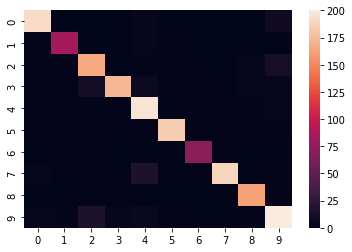

In [55]:
heat_map(x_test, y_test, model_tunned)

# Saving the model

In [46]:
model_json = model_tunned.to_json()
with open('models/cnn_tunned.json', 'w') as json_file:
    json_file.write(model_json)

In [47]:
# Serialize weights to HDF5
model_tunned.save_weights('models/cnn_tunned.h5')
print('Model saved')

Model saved
